In [1]:
import sys
sys.path.append('/home/jhernandez/Work//')
sys.path.append('/home/jhernandez/Work/python_tools/')

from defaults import *
from tqdm import tqdm

import seawater as sw
from collections import defaultdict

import requests
from bs4 import BeautifulSoup

## Plot RV and simultaneous Glider Observations assimilated

#### Load Observation DataFrame

In [2]:
df = pd.read_csv('./simulations_and_innovations_at_observations_noGLI-sim_daily-interp-avg.txt', 
                 index_col=0)#, parse_dates=[11,12,13], infer_datetime_format=True)
df['assim_date'] = pd.to_datetime(df['assim_date'])
df['dates_obs'] = pd.to_datetime(df['dates_obs'])

#### Get RV files path 

In [3]:
year = '2017'
product_level = 'L1_corr'

url_rvs = "https://thredds.socib.es/thredds/catalog/research_vessel/ctd/"
path_opendap = "http://thredds.socib.es/thredds/dodsC/research_vessel/ctd/"

page = requests.get(url_rvs + 'catalog.html')
soup = BeautifulSoup(page.content, "html.parser")

rv_files_opendap = []

for i in soup.find_all('a'):
    if "_rv-" in i.get_text():
        rv_name = url_rvs + i.get_text()
        rv_name_opendap = path_opendap + i.get_text()
        
        page2 = requests.get(F"{rv_name}/{product_level}/{year}/catalog.html")    
        soup2 = BeautifulSoup(page2.content, "html.parser")

        for ii in soup2.find_all('a'):

            if ".nc" in ii.get_text():
                rv_files_opendap.append(F"{rv_name_opendap}/{product_level}/{year}/{ii.get_text()}")


#### Get bathimetry

In [4]:
bat = tools.get_bathimetry('GEBCO_1min')
import cmocean as cm

bati = bat.where((bat.elevation<0) & (bat.elevation>-3500))

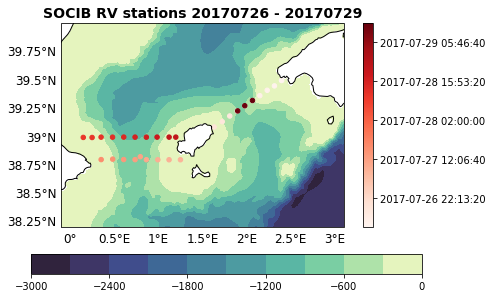

In [7]:
# Load RV file    
ds_rv = xr.open_dataset(rv_files_opendap[0])
# Get dates
tmin_rv = pd.to_datetime(str(ds_rv.time.min().values)).strftime('%Y%m%d')
tmax_rv = pd.to_datetime(str(ds_rv.time.max().values)).strftime('%Y%m%d')

fig_rv = plt.figure(figsize=(7,5))
ax, gl = tools.make_map(limits=[-0.1,3.1,38.2,40.0])
plt.contourf(bat.lon, bat.lat, bati.elevation, transform=gl.crs, cmap=cm.cm.deep_r, levels=10)
plt.colorbar(orientation="horizontal", pad=0.1)#,fraction=0.06)

plt.scatter(ds_rv.LON, ds_rv.LAT, 20, ds_rv.time, transform=gl.crs, cmap='Reds')
cb = plt.colorbar()

cblabels = [datetime.fromtimestamp(t // 1000000000) for t in cb.get_ticks() ]
cb.ax.set_yticklabels(cblabels)
plt.title(F"SOCIB RV stations {tmin_rv} - {tmax_rv}", fontsize=14, fontweight='bold')
# plt.tight_layout()
plt.show()

In [5]:
df_gli = df[df['source'].str.contains('GLI')].reset_index(drop=True)

In [8]:
df_gli.head()

tmin_rv = pd.to_datetime(str(ds_rv.time.min().values))#.strftime('%Y-%m-%d')
tmax_rv = pd.to_datetime(str(ds_rv.time.max().values))#.strftime('%Y-%m-%d')

k1 = (df_gli['dates_obs']>= tmin_rv - timedelta(days=3)) & (df_gli['assim_date']<= tmax_rv)
k2 = df_gli['depth'] < 20

df_gli_rv = df_gli[k1 & k2]
# tmin_rv

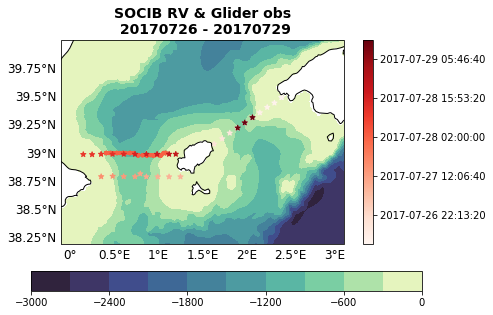

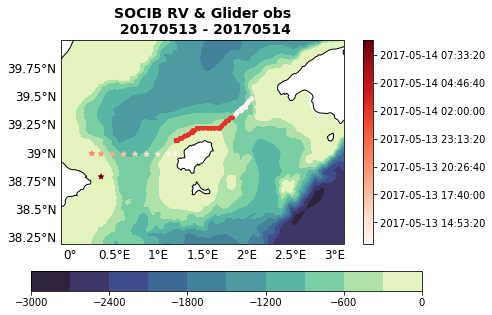

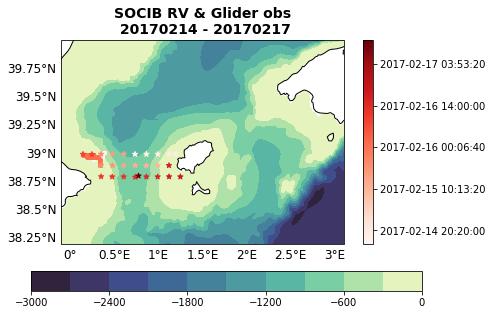

In [71]:
for file in rv_files_opendap:
    # Load RV file    
    ds_rv = xr.open_dataset(file)
    # Get dates
    tmin_rv = pd.to_datetime(str(ds_rv.time.min().values))
    tmax_rv = pd.to_datetime(str(ds_rv.time.max().values))
    
    # Get Glider Observations Coincident with RV
    k1 = (df_gli['dates_obs']>= tmin_rv - timedelta(days=3)) & (df_gli['assim_date']<= tmax_rv)
    k2 = df_gli['depth'] < 20
    df_gli_rv = df_gli[k1 & k2]

    fig_rv = plt.figure(figsize=(7,5))
    ax, gl = tools.make_map(limits=[-0.1,3.1,38.2,40.0])
    plt.contourf(bat.lon, bat.lat, bati.elevation, transform=gl.crs, cmap=cm.cm.deep_r, levels=10)
    plt.colorbar(orientation="horizontal", pad=0.1)#,fraction=0.06)

    plt.scatter(df_gli_rv['longitude'], df_gli_rv['latitude'], 10, df_gli_rv['assim_date'],
                transform=gl.crs, cmap='Reds',vmin=ds_rv.time[0], vmax=ds_rv.time[-1],
                label='Glider')

    plt.scatter(ds_rv.LON, ds_rv.LAT, 30, ds_rv.time, 
                transform=gl.crs, cmap='Reds',vmin=ds_rv.time[0], vmax=ds_rv.time[-1],
                marker='*', label='RV')
    cb = plt.colorbar()
    cblabels = [datetime.fromtimestamp(t // 1000000000) for t in cb.get_ticks() ]
    cb.ax.set_yticklabels(cblabels)

    # plt.legend()
    plt.title(F"SOCIB RV & Glider obs\n {tmin_rv.strftime('%Y%m%d')} - {tmax_rv.strftime('%Y%m%d')}", fontsize=14, fontweight='bold')
    # plt.tight_layout()
    plt.show()
    
    outfile = F"/LOCALDATA/Plots/EuroSea/WP4/RV_stations_{tmin_rv.strftime('%Y%m%d')}_{tmax_rv.strftime('%Y%m%d')}.png"
    fig_rv.savefig(outfile, dpi=250, transparent=False, facecolor="w")

In [31]:
pd.to_datetime(str(ds_rv.time.min().values))

Timestamp('2017-07-26 09:49:44')

In [ ]:

for file in rv_files_opendap:
    # Load RV file    
    ds_rv = xr.open_dataset(file)
    # Get dates
    tmin_rv = pd.to_datetime(str(ds_rv.time.min().values)).strftime('%Y%m%d')
    tmax_rv = pd.to_datetime(str(ds_rv.time.max().values)).strftime('%Y%m%d')

    fig_rv = plt.figure(figsize=(7,5))
    ax, gl = tools.make_map(limits=[-0.1,1.9,38.5,39.4])
    plt.contourf(bat.lon, bat.lat, bati.elevation, transform=gl.crs, cmap=cm.cm.deep_r, levels=10)
    plt.colorbar(orientation="horizontal", pad=0.1)#,fraction=0.06)

    plt.scatter(ds_rv.LON, ds_rv.LAT, 20, ds_rv.time, transform=gl.crs, cmap='Reds')
    cb = plt.colorbar()

    cblabels = [datetime.fromtimestamp(t // 1000000000) for t in cb.get_ticks() ]
    cb.ax.set_yticklabels(cblabels)
    plt.title(F"SOCIB RV stations {strdate_min} - {strdate_max}", fontsize=14, fontweight='bold')
    # plt.tight_layout()
    plt.show()
    
#     outfile = F'/LOCALDATA/Plots/EuroSea/WP4/RV_stations_{strdate_min}_{strdate_max}.png'
#     fig_profs.savefig(outfile, dpi=250, transparent=False, facecolor="w")

### Plot Profiles of RV and Glider

In [13]:
# Load RV file    
ds_rv = xr.open_dataset(rv_files_opendap[0])
# Get dates
tmin_rv = pd.to_datetime(str(ds_rv.time.min().values))
tmax_rv = pd.to_datetime(str(ds_rv.time.max().values))

# Get Glider Observations Coincident with RV
k1 = (df_gli['dates_obs']>= tmin_rv - timedelta(days=3)) & (df_gli['assim_date']<= tmax_rv)
k2 = df_gli['depth'] < 20
kt = df_gli['nb_sou'] == 1
ks = df_gli['nb_sou'] == 2
df_gli_rv_t = df_gli[k1 & kt]

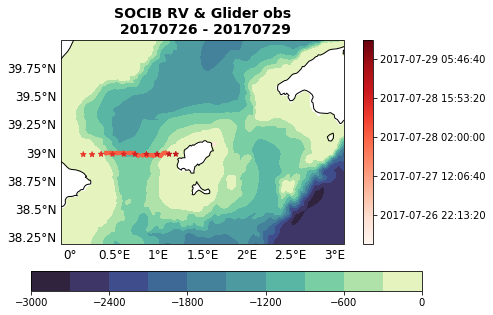

In [29]:
df_gli_rv = df_gli[k1 & k2]

fig_rv = plt.figure(figsize=(7,5))
ax, gl = tools.make_map(limits=[-0.1,3.1,38.2,40.0])
plt.contourf(bat.lon, bat.lat, bati.elevation, transform=gl.crs, cmap=cm.cm.deep_r, levels=10)
plt.colorbar(orientation="horizontal", pad=0.1)#,fraction=0.06)

plt.scatter(df_gli_rv['longitude'], df_gli_rv['latitude'], 10, df_gli_rv['assim_date'],
            transform=gl.crs, cmap='Reds',vmin=ds_rv.time[0], vmax=ds_rv.time[-1],
            label='Glider')

plt.scatter(ds_rv2.LON, ds_rv2.LAT, 30, ds_rv2.time, 
            transform=gl.crs, cmap='Reds',vmin=ds_rv.time[0], vmax=ds_rv.time[-1],
            marker='*', label='RV')
cb = plt.colorbar()
cblabels = [datetime.fromtimestamp(t // 1000000000) for t in cb.get_ticks() ]
cb.ax.set_yticklabels(cblabels)

# plt.legend()
plt.title(F"SOCIB RV & Glider obs\n {tmin_rv.strftime('%Y%m%d')} - {tmax_rv.strftime('%Y%m%d')}", fontsize=14, fontweight='bold')
# plt.tight_layout()
plt.show()


In [27]:
ds_rv2 = ds_rv.where( (ds_rv.LAT<39.1) & (ds_rv.LAT>38.9), drop=True )

In [49]:
import seawater as sw

In [51]:
time_rv = np.tile(ds_rv2.time.values,(192,1)).flatten()
lon_rv = np.tile(ds_rv2.LON.values,(192,1)).flatten()
temp_rv = ds_rv2.WTR_TEM_01.values.flatten()
temp_qc = ds_rv2.QC_WTR_TEM_01.values.flatten()
salt_rv = ds_rv2.SALT_01_CORR.values.flatten()
depth_rv = ds_rv2.DEPTH.values.flatten()

ptemp_rv = sw.ptmp(salt_rv, temp_rv, depth_rv)


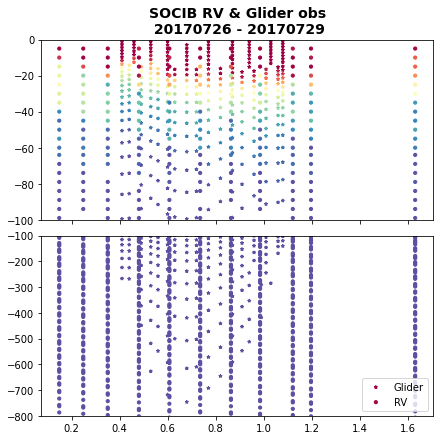

In [99]:
from matplotlib.gridspec import GridSpec

dfp = df_gli_rv_t

fig = plt.figure(figsize=(6,6), constrained_layout=True)
gs = GridSpec(8,4, figure=fig)
ax1 = fig.add_subplot(gs[0:4, :])
ax2 = fig.add_subplot(gs[4:, :])    


# plt.figure(figsize=(10,8))
ax1.scatter(dfp['longitude'], -dfp['depth'], 10, dfp['value'], marker='*', vmin=14, vmax=26.5, cmap='Spectral_r', label='Glider')
ax1.scatter(lon_rv, -depth_rv, 10, ptemp_rv, vmin=14, vmax=26.5, cmap='Spectral_r', label='RV')
ax1.set_ylim((-100,0))
ax1.set_xticklabels([])
# plt.figure(figsize=(10,8))
ax2.scatter(dfp['longitude'], -dfp['depth'], 10, dfp['value'], marker='*', vmin=14, vmax=26.5, cmap='Spectral_r', label='Glider')
ax2.scatter(lon_rv, -depth_rv, 10, ptemp_rv, vmin=14, vmax=26.5, cmap='Spectral_r', label='RV')
ax2.set_ylim((-800,-100))

ax1.set_title(F"SOCIB RV & Glider obs\n {tmin_rv.strftime('%Y%m%d')} - {tmax_rv.strftime('%Y%m%d')}", fontsize=14, fontweight='bold')
plt.legend()

fig.savefig('/LOCALDATA/Plots/EuroSea/WP4/rv_vs-glider_profile.png', dpi=250, transparent=False, facecolor="w")

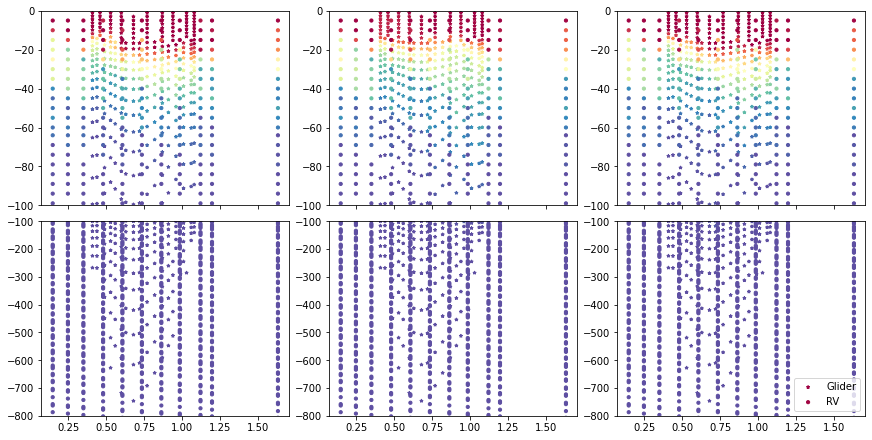

In [68]:

fig = plt.figure(figsize=(12,6), constrained_layout=True)


gs = GridSpec(8,6, figure=fig)
ax1 = fig.add_subplot(gs[0:4, 0:2])
ax2 = fig.add_subplot(gs[4:, 0:2]) 
ax3 = fig.add_subplot(gs[0:4, 2:4])
ax4 = fig.add_subplot(gs[4:, 2:4]) 
ax5 = fig.add_subplot(gs[0:4, 4:6])
ax6 = fig.add_subplot(gs[4:, 4:6]) 



# plt.figure(figsize=(10,8))
ax1.scatter(dfp['longitude'], -dfp['depth'], 10, dfp['value'], marker='*', vmin=14, vmax=26.5, cmap='Spectral_r', label='Glider')
ax1.scatter(lon_rv, -depth_rv, 10, ptemp_rv, vmin=14, vmax=26.5, cmap='Spectral_r', label='RV')
ax1.set_ylim((-100,0))
ax1.set_xticklabels([])
# plt.figure(figsize=(10,8))
ax2.scatter(dfp['longitude'], -dfp['depth'], 10, dfp['value'], marker='*', vmin=14, vmax=26.5, cmap='Spectral_r', label='Glider')
ax2.scatter(lon_rv, -depth_rv, 10, ptemp_rv, vmin=14, vmax=26.5, cmap='Spectral_r', label='RV')
ax2.set_ylim((-800,-100))

ax3.scatter(dfp['longitude'], -dfp['depth'], 10, dfp['background'], marker='*', vmin=14, vmax=26.5, cmap='Spectral_r', label='Glider')
ax3.scatter(lon_rv, -depth_rv, 10, ptemp_rv, vmin=14, vmax=26.5, cmap='Spectral_r', label='RV')
ax3.set_ylim((-100,0))
ax3.set_xticklabels([])
# plt.figure(figsize=(10,8))
ax4.scatter(dfp['longitude'], -dfp['depth'], 10, dfp['background'], marker='*', vmin=14, vmax=26.5, cmap='Spectral_r', label='Glider')
ax4.scatter(lon_rv, -depth_rv, 10, ptemp_rv, vmin=14, vmax=26.5, cmap='Spectral_r', label='RV')
ax4.set_ylim((-800,-100))


ax5.scatter(dfp['longitude'], -dfp['depth'], 10, dfp['analysis'], marker='*', vmin=14, vmax=26.5, cmap='Spectral_r', label='Glider')
ax5.scatter(lon_rv, -depth_rv, 10, ptemp_rv, vmin=14, vmax=26.5, cmap='Spectral_r', label='RV')
ax5.set_ylim((-100,0))
ax5.set_xticklabels([])
# plt.figure(figsize=(10,8))
ax6.scatter(dfp['longitude'], -dfp['depth'], 10, dfp['analysis'], marker='*', vmin=14, vmax=26.5, cmap='Spectral_r', label='Glider')
ax6.scatter(lon_rv, -depth_rv, 10, ptemp_rv, vmin=14, vmax=26.5, cmap='Spectral_r', label='RV')
ax6.set_ylim((-800,-100))



plt.legend()

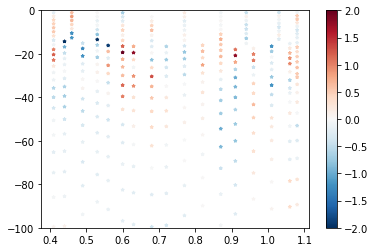

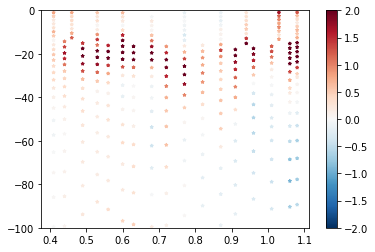

In [97]:

plt.figure()
plt.scatter(dfp['longitude'], -dfp['depth'], 10, dfp['value'] - dfp['analysis'], marker='*', cmap='RdBu_r', label='Glider', vmin=-2, vmax=2)
plt.colorbar()
plt.ylim((-100,0))
plt.show()

plt.figure()
plt.scatter(dfp['longitude'], -dfp['depth'], 10, dfp['analysis'] - dfp['GLI'], marker='*', cmap='RdBu_r', label='Glider', vmin=-2, vmax=2)
plt.colorbar()
plt.ylim((-100,0))
plt.show()



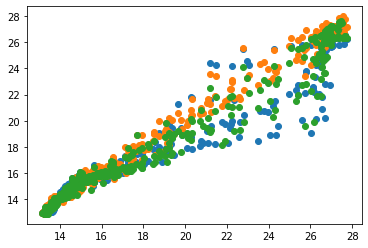

In [81]:
plt.scatter(dfp['value'], dfp['background'])
plt.scatter(dfp['value'], dfp['analysis'])
plt.scatter(dfp['value'], dfp['GLI'])

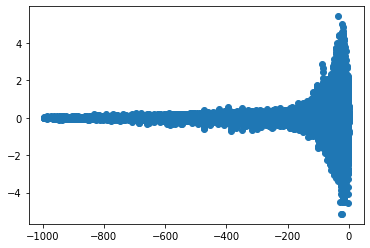

In [90]:
plt.scatter(-df_gli['depth'], df_gli['analysis'] - df_gli['GLI'])

In [93]:
import seaborn as sns

In [94]:
df_sns = df_gli[df_gli['nb_sou']==1]
df_sns['diff'] = df_sns['analysis'] - df_sns['GLI']

In [96]:
sns.jointplot(data=df_sns, x="analysis", y="GLI")

In [113]:
dfp.shape

(462, 28)

In [114]:
lonlat = dfp[['longitude', 'latitude']]
lonlat = lonlat.drop_duplicates().reset_index(drop=True)
lonlat

for i in range(lonlat.shape[0]):
    
    print(dfp[dfp['longitude']==lonlat.iloc[i]['longitude']].shape[0])

28
20
9
21
2
18
13
23
31
24
31
23
30
22
31
23
31
23
7
22
30
